In [1]:
from modules.spoticharts import SpotiCharts
import numpy as np
import pandas as pd
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
sc = SpotiCharts()

In [3]:
df_pl = sc.get_all_top_200(country_codes=['pl'])

In [5]:
df_pl.head()

,artist,position,date,streams,track_name,region,spotify_id,tempo,liveness,acousticness,loudness,danceability,duration_ms,valence,instrumentalness,speechiness,energy
0,DJ Snake,1,2017-01-01,26290,Let Me Love You,pl,4pdPtRcBmOSQDlJ3Fk945m,199.864,0.122,0.0784,-5.309,0.476,205947,0.142,0.00001,0.0576,0.718
1,DJ Snake,4,2017-01-02,26747,Let Me Love You,pl,4pdPtRcBmOSQDlJ3Fk945m,199.864,0.122,0.0784,-5.309,0.476,205947,0.142,0.00001,0.0576,0.718
2,DJ Snake,5,2017-01-03,26540,Let Me Love You,pl,4pdPtRcBmOSQDlJ3Fk945m,199.864,0.122,0.0784,-5.309,0.476,205947,0.142,0.00001,0.0576,0.718
3,DJ Snake,5,2017-01-04,26959,Let Me Love You,pl,4pdPtRcBmOSQDlJ3Fk945m,199.864,0.122,0.0784,-5.309,0.476,205947,0.142,0.00001,0.0576,0.718
4,DJ Snake,7,2017-01-06,27898,Let Me Love You,pl,4pdPtRcBmOSQDlJ3Fk945m,199.864,0.122,0.0784,-5.309,0.476,205947,0.142,0.00001,0.0576,0.718


In [4]:
def extract_data(dataframe, artist_name='Billie Eilish'):
    df = df_pl[df_pl['artist'] == artist_name][['date','position']]
    df.sort_values(by='date',inplace=True)
    dates = df['date'].values
    date_series = pd.date_range(dates[0],dates[-1])
    df.groupby(['date']).position.idxmin()
    df = df.loc[df.groupby(['date']).position.idxmin()]
    df.set_index('date', inplace=True)
    s = df['position']
    s = s.reindex(index=date_series)
    s = s.interpolate()
    return s

In [5]:
def get_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [24]:
def split_series_train_test(series, scale=False, train_size = 0.8, k=None):
    values = series.values.reshape(-1, 1)
    if k:
        values = moving_average(values, k)
    features_set = []
    labels = []
    for i in range(60, len(series)):
        features_set.append(values[i-60:i])
        labels.append(values[i])
    features_set = np.array(features_set)
    labels = np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    N = len(features_set)
    boundary = int(train_size * N)
    X_train, y_train = features_set[:boundary], labels[:boundary]
    X_test, y_test= features_set[boundary:], labels[boundary:]
    return X_train, X_test, y_train, y_test

In [12]:
def plot_results(y_test, predictions):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(predictions , color='red', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Min position')
    plt.legend()
    plt.show()

In [7]:
series = extract_data(df_pl)

<AxesSubplot:>

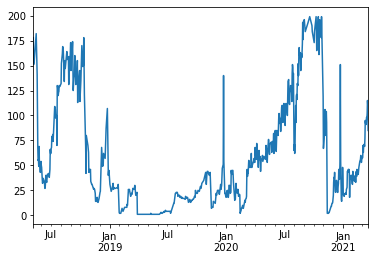

In [8]:
series.plot()

In [30]:
def check_for_params(series, k=None):
    X_train, X_test, y_train, y_test = split_series_train_test(series, k)
    model = get_model((X_train.shape[1], 1))
    history_model = model.fit(X_train, y_train, epochs = 50, batch_size = 8)
    predictions = model.predict(X_test)
    mse = ((y_test - predictions)**2).mean()
    print('MSE:', mse)
    plot_results(y_test, predictions)

Epoch 1/50
99/99 [==============================] - 6s 30ms/step - loss: 4989.1672
Epoch 2/50
99/99 [==============================] - 3s 29ms/step - loss: 4150.5843
Epoch 3/50
99/99 [==============================] - 3s 30ms/step - loss: 3612.9254
Epoch 4/50
99/99 [==============================] - 3s 29ms/step - loss: 3535.0826
Epoch 5/50
99/99 [==============================] - 3s 30ms/step - loss: 3117.1826
Epoch 6/50
99/99 [==============================] - 3s 31ms/step - loss: 2973.7005
Epoch 7/50
99/99 [==============================] - 3s 31ms/step - loss: 2968.6209
Epoch 8/50
99/99 [==============================] - 3s 31ms/step - loss: 2476.8484
Epoch 9/50
99/99 [==============================] - 3s 31ms/step - loss: 2434.7365
Epoch 10/50
99/99 [==============================] - 3s 32ms/step - loss: 1932.1872
Epoch 11/50
99/99 [==============================] - 3s 32ms/step - loss: 1854.8420
Epoch 12/50
99/99 [==============================] - 3s 33ms/step - loss: 1972.5642
E

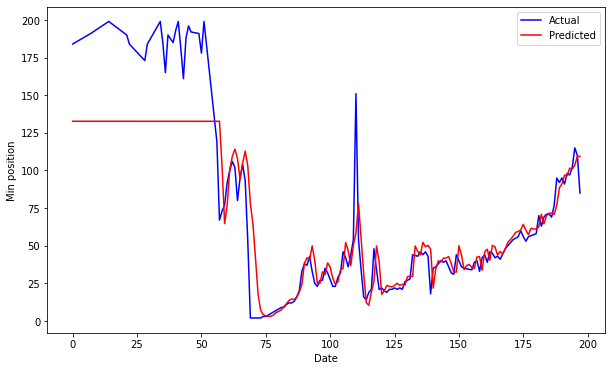

In [31]:
check_for_params(series)

Epoch 1/50
99/99 [==============================] - 7s 35ms/step - loss: 4509.1955
Epoch 2/50
99/99 [==============================] - 3s 30ms/step - loss: 4126.3179
Epoch 3/50
99/99 [==============================] - 3s 30ms/step - loss: 3307.7744
Epoch 4/50
99/99 [==============================] - 3s 31ms/step - loss: 3223.7504
Epoch 5/50
99/99 [==============================] - 3s 32ms/step - loss: 3208.0122
Epoch 6/50
99/99 [==============================] - 3s 32ms/step - loss: 2817.8168
Epoch 7/50
99/99 [==============================] - 3s 31ms/step - loss: 2540.6985
Epoch 8/50
99/99 [==============================] - 3s 32ms/step - loss: 2253.6855
Epoch 9/50
99/99 [==============================] - 3s 32ms/step - loss: 2375.5063
Epoch 10/50
99/99 [==============================] - 3s 31ms/step - loss: 1880.7920
Epoch 11/50
99/99 [==============================] - 3s 32ms/step - loss: 2108.2820
Epoch 12/50
99/99 [==============================] - 3s 32ms/step - loss: 1729.9124
E

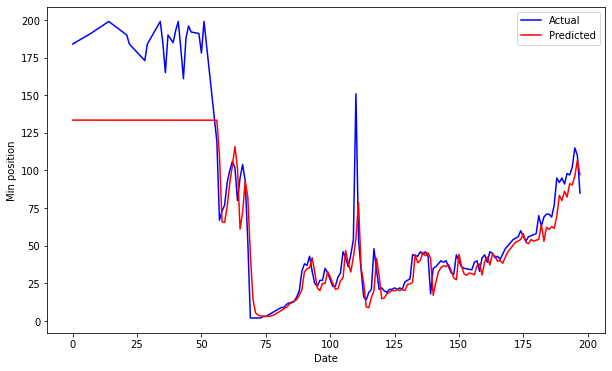

In [32]:
check_for_params(series, k=5)

### Predictions with the use of MA

In [20]:
from numpy import mean
from sklearn.metrics import mean_squared_error

def test_ma(series, k=5):
    X = series.values
    history = [X[i] for i in range(k)]
    test = [X[i] for i in range(k, len(X))]
    predictions = []

    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-k,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)

    error = mean_squared_error(test, predictions)
    print('MSE', error)
    plt.figure(figsize=(20,12))

    plt.plot(list(series.index)[k:], test, 'r')
    plt.plot(list(series.index)[k:], predictions, 'g')
    plt.show()

MSE 181.56762274170276


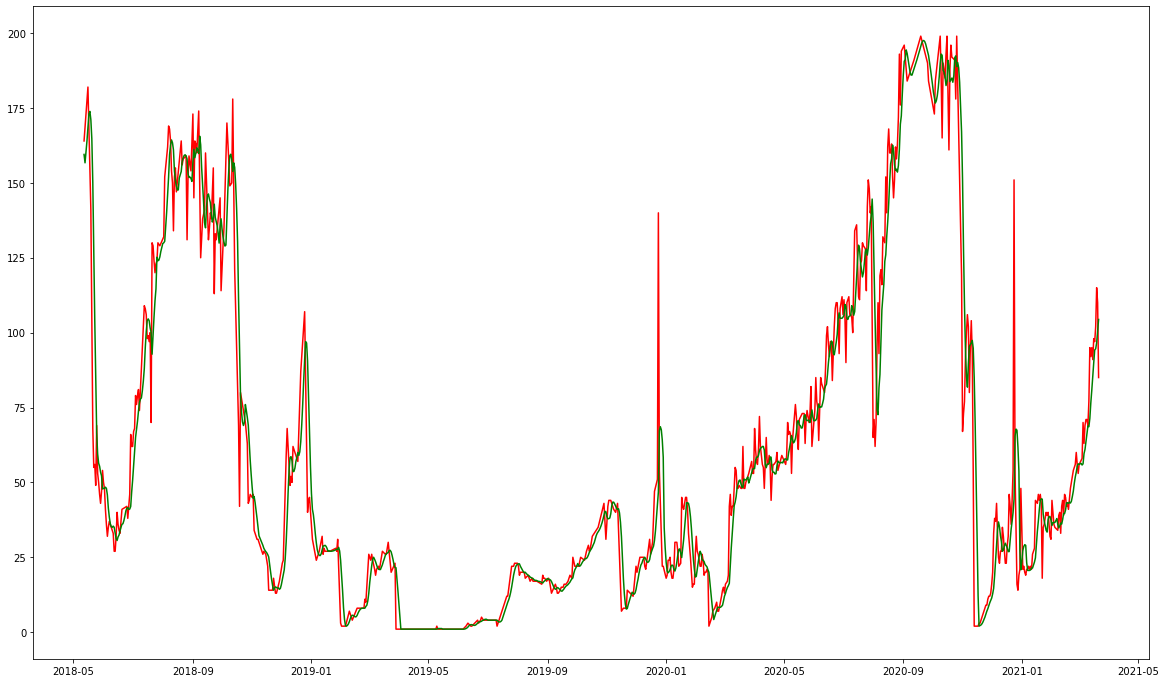

In [21]:
test_ma(series, 5)

MSE 98.56668028507876


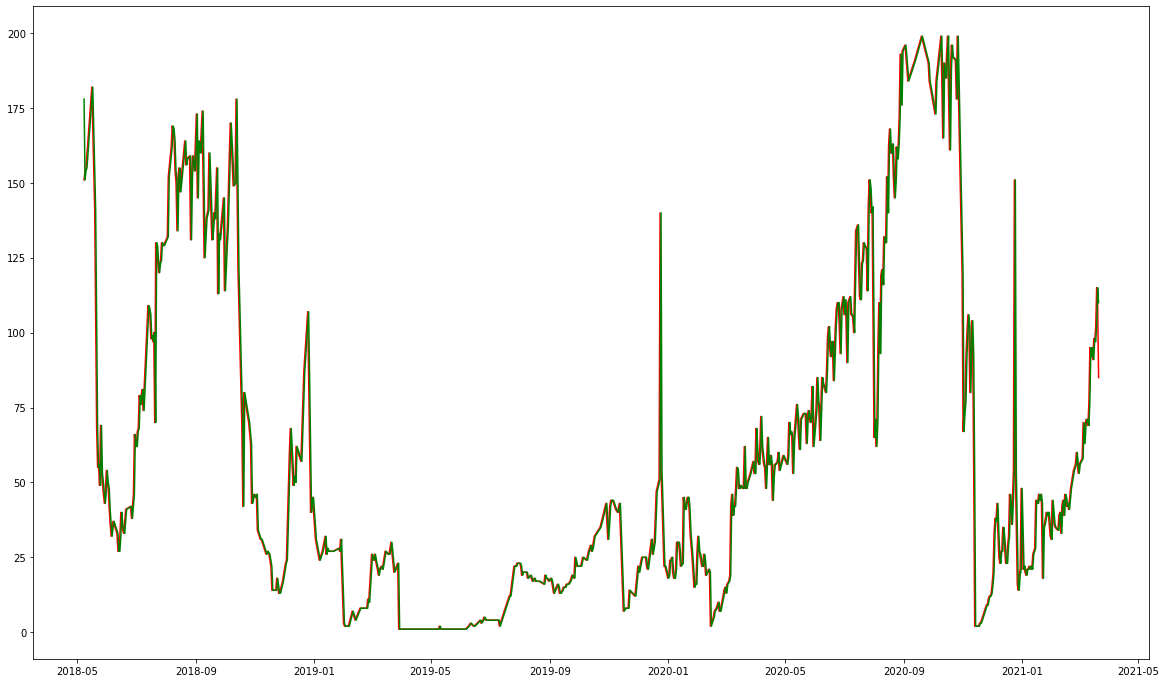

In [22]:
test_ma(series, 1)